###
## Phase Neural Operator (PhaseNO)
### PhaseNO for multi-station earthquake detection and phase picking
### - Predict on continuous seismic data with the pretrained model - 
### - (March 31, 2025) Version 1.0.1: Optimized the implementation to reduce computational overhead. See README.txt for detailed changes.

##### Author: Hongyu Sun
##### Email: hongyu-sun@outlook.com

In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import gc 
import numpy as np
import pandas as pd
import json
import random; random.seed(10)
import obspy
from tqdm import tqdm
from datetime import datetime, timedelta
from collections import namedtuple

import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch_geometric.nn import MessagePassing

import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold', 
        'size'   : 12}
matplotlib.rc('font', **font)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### define the model: PhaseNO

In [2]:
class Feedforward(torch.nn.Module):
        def __init__(self, channel_size, hidden_size):  
            super(Feedforward, self).__init__()
            self.channel = channel_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.channel*2+4, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.channel)
            
        def forward(self, x): #[E, in_channels, NT]
            x = x.permute(0,2,1)
            x = self.fc1(x)
            x = F.gelu(x)
            x = self.fc2(x)
            return x.permute(0,2,1)

class Feedforward_aggre(torch.nn.Module):
        def __init__(self, channel_size, hidden_size):  
            super(Feedforward_aggre, self).__init__()
            self.channel = channel_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.channel*2, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.channel)
            
        def forward(self, x): #[E, in_channels, NT]
            x = x.permute(0,2,1)
            x = self.fc1(x)
            x = F.gelu(x)
            x = self.fc2(x)
            return x.permute(0,2,1)

class GNO(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='mean',node_dim=-3)
        activation= nn.GELU() 
        dropout=0.1
        hidden = in_channels*2*2
        self.edge  = Feedforward(in_channels,hidden)
        self.aggre = Feedforward_aggre(in_channels,hidden)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        return self.propagate(edge_index[:2,:].to(torch.int64), x=x, xloc=edge_index[2:,:])

    def message(self, x_i, x_j, xloc):

        #x_i.shape: torch.Size([E, channels, NT])
        nedge = xloc.shape[1]
        loc_i = torch.zeros((nedge,2,x_i.shape[-1]),device=x_i.device)
        loc_j = torch.zeros((nedge,2,x_j.shape[-1]),device=x_j.device)
        for e in np.arange(nedge):
            loc_i[e,0,:] = xloc[0,e]
            loc_i[e,1,:] = xloc[1,e]
            loc_j[e,0,:] = xloc[2,e]
            loc_j[e,1,:] = xloc[3,e]

        # concatenate x_i and x_j along channel dimension
        tmp = torch.cat([x_i, loc_i, x_j, loc_j], dim=1)  # tmp has shape [E, 2 * in_channels+4, NT]
        ans = self.edge(tmp)
        return ans
    
    def update(self, aggr_out, x):
        #aggr_out.shape: torch.Size([5, 16, 6100])
        #x.shape: torch.Size([5, 16, 6100])
        tmp = torch.cat([aggr_out, x], dim=1)  # tmp has shape [E, 2 * in_channels, NT]
        ans = self.aggre(tmp)
        return ans

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.dim1 = dim1
        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand((in_channels, out_channels, self.modes1), dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, modes on t), (in_channel, out_channel, modes on t) -> (batch, out_channel, modes on t)

        #print('einsum input', input.shape)
        #print('einsum weights', weights.shape)        

        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x, dim1=None):

        if dim1 is not None:
            self.dim1 = dim1

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x, norm = 'forward')

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  self.dim1//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=self.dim1 , norm = 'forward')
        return x

class pointwise_op_1D(nn.Module):
    """
    All variables are consistent with the SpectralConv1d_Uno class.
    """
    def __init__(self, in_codim, out_codim,dim1):
        super(pointwise_op_1D,self).__init__()
        self.conv = nn.Conv1d(int(in_codim), int(out_codim), 1)
        self.dim1 = int(dim1)

    def forward(self,x, dim1 = None):
        if dim1 is None:
            dim1 = self.dim1
        x_out = self.conv(x)

        x_out = torch.nn.functional.interpolate(x_out, size = dim1,mode = 'linear',align_corners=True)#, antialias= True)
        return x_out

class FNO1D(nn.Module):
    """
    Normalize = if true performs InstanceNorm1d on the output.
    Non_Lin = if true, applies point wise nonlinearity.
    All other variables are consistent with the SpectralConv1d_Uno class.
    """
    def __init__(self, in_codim, out_codim, modes1, dim1, Normalize = True, Non_Lin = True):
        super(FNO1D,self).__init__()
        self.conv = SpectralConv1d(in_codim, out_codim, int(dim1), int(modes1))
        self.w = pointwise_op_1D(in_codim, out_codim, int(dim1))
        self.normalize = Normalize
        self.non_lin = Non_Lin
        if Normalize:
            self.normalize_layer = torch.nn.InstanceNorm1d(int(out_codim),affine=True)

    def forward(self,x):#, dim1 = None):
        """
        input shape = (batch, in_codim, input_dim1)
        output shape = (batch, out_codim, dim1)
        """
        x1_out = self.conv(x)#,dim1)
        x2_out = self.w(x)#,dim1)
        x_out = x1_out + x2_out
        if self.normalize:
            x_out = self.normalize_layer(x_out)
        if self.non_lin:
            x_out = F.gelu(x_out)
        return x_out

class PhaseNO(pl.LightningModule):

    def __init__(self, modes = 24, width = 48):
        super(PhaseNO,self).__init__()

        self.modes1 = modes
        self.width  = width
        self.padding = 50 # pad the domain if input is non-periodic

        self.criterion =  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5]))
        self.loss_weights = [0.5,0.5]

        self.fc0 = nn.Linear(6, self.width)

        self.fno0 = FNO1D(self.width, self.width, self.modes1, 3000+self.padding*2)
        self.gno0 = GNO(self.width)

        self.fno1 = FNO1D(self.width, self.width*2, self.modes1/2, 750)
        self.gno1 = GNO(self.width*2)

        self.fno2 = FNO1D(self.width*2, self.width*4, self.modes1/3, 200)
        # self.gno2 = GNO(self.width*4)

        # self.fno3 = FNO1D(self.width*4, self.width*4, self.modes1/3, 200)
        self.gno3 = GNO(self.width*4)

        self.fno4 = FNO1D(self.width*8, self.width*2, self.modes1/3, 750)
        self.gno4 = GNO(self.width*2)

        self.fno5 = FNO1D(self.width*4, self.width*1, self.modes1/2, 3000+self.padding*2)
        self.gno5 = GNO(self.width*1)

        self.fno6 = FNO1D(self.width*2, self.width, self.modes1, 3000+self.padding*2)
        
        self.fno7 = FNO1D(self.width, self.width, self.modes1, 3000+self.padding*2, Non_Lin = False)

        self.fc1 = nn.Linear(self.width, self.width*2)
        self.fc2 = nn.Linear(self.width*2, 2)

    def forward(self, data):

        """
        By default, the predict_step() method runs the forward() method. 
        In order to customize this behaviour, simply override the predict_step() method.
        trainer = Trainer()
        predictions = trainer.predict(model, dataloaders=test_dataloader)
        """
        x, edge_index = data[0], data[2]

        #x shape: [nstation, nchannel, nt]
        grid = self.get_grid(x.shape,x.device)

        x = torch.cat((x, grid), dim=1)
        x = F.pad(x, [self.padding,self.padding], mode ='reflect', value=0) # pad the domain if input is non-periodic

        x = np.squeeze(x) # nstation, nchannel, nt
        edge_index=np.squeeze(edge_index) # 2, nedge

        x = x.permute(0, 2, 1) # nstation, nt, nchannel
        x = self.fc0(x)
        x = x.permute(0, 2, 1) # nstation, nchannel,nt 

        x0 = self.fno0(x)
        x = self.gno0(x0,edge_index)
        x1 = self.fno1(x)
        x = self.gno1(x1,edge_index)
        x2 = self.fno2(x)

        # x = self.gno2(x2,edge_index)
        # x = self.fno3(x)
        x = self.gno3(x2,edge_index)
        x = torch.cat([x2, x], dim=1) 
        
        x = self.fno4(x)
        x = self.gno4(x,edge_index)
        x = torch.cat([x1, x], dim=1) 

        x = self.fno5(x)
        x = self.gno5(x,edge_index)
        x = torch.cat([x0, x], dim=1) 
    
        x = self.fno6(x)
        x = self.fno7(x)

        x = x[...,self.padding:-self.padding]

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x) #nstation, nt, nchannel

        return x.permute(0, 2, 1)

    def get_grid(self, shape, device): 

        nstation, size_t = shape[-3], shape[-1]   # nstation, nchannel, nt
        gridx = torch.tensor(np.linspace(0, 1, size_t), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_t).repeat([nstation, 1, 1])
        return gridx.to(device)

    def training_step(self, batch, batch_idx):

        y = batch[1]
        y = np.squeeze(y)
        
        y_hat = self.forward(batch) 

        y_hatP = y_hat[:,0,:].reshape(-1,1)
        yP = y[:,0,:].reshape(-1,1)
        lossP = self.criterion(y_hatP, yP)* self.loss_weights[0]

        y_hatS = y_hat[:,1,:].reshape(-1,1)
        yS = y[:,1,:].reshape(-1,1)
        lossS = self.criterion(y_hatS, yS)* self.loss_weights[1]
        
        loss = lossP+lossS
        # Update loss
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True) 
        self.log("train_lossP", lossP, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_lossS", lossS, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, #must be this name
                "train_lossP": lossP,
                "train_lossS": lossS                
                }

    def validation_step(self, batch, batch_idx):

        y = batch[1]
        y = np.squeeze(y)

        y_hat = self.forward(batch)
        
        y_hatP = y_hat[:,0,:].reshape(-1,1)
        yP = y[:,0,:].reshape(-1,1)
        lossP = self.criterion(y_hatP, yP)* self.loss_weights[0]

        y_hatS = y_hat[:,1,:].reshape(-1,1)
        yS = y[:,1,:].reshape(-1,1)
        lossS = self.criterion(y_hatS, yS)* self.loss_weights[1]

        loss = lossP+lossS
        
        # Update loss
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_lossP", lossP, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_lossS", lossS, on_epoch=True, prog_bar=True, logger=True)

        return {"val_loss": loss,
                "val_lossP": lossP,
                "val_lossS": lossS      
        }
    
    def configure_optimizers(self):
        # build optimizer and schedule learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "loss",
                    "interval": "epoch",
                    "frequency": 100,
                       },
        }

In [3]:
def _trim_nan(x):
        """
        Removes all starting and trailing nan values from a 1D array and returns the new array and the number of NaNs
        removed per side.
        """
        mask_forward = np.cumprod(np.isnan(x)).astype(
            bool
        )  # cumprod will be one until the first non-Nan value
        x = x[~mask_forward]
        mask_backward = np.cumprod(np.isnan(x)[::-1])[::-1].astype(
            bool
        )  # Double reverse for a backwards cumprod
        x = x[~mask_backward]

        return x, np.sum(mask_forward.astype(int)), np.sum(mask_backward.astype(int))

In [4]:
# codes for picking
# clone from PhaseNet: https://github.com/AI4EPS/PhaseNet

def _detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False):

    """
    __author__ = "Marcos Duarte, https://github.com/demotu"
    __version__ = "1.0.6"
    __license__ = "MIT"

    Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
        
    mph : {None, number}, default=None
        detect peaks that are greater than minimum peak height.
        
    mpd : int, default=1
        detect peaks that are at least separated by minimum peak distance (in number of data).
        
    threshold : int, default=0
        detect peaks (valleys) that are greater (smaller) than `threshold in relation to their immediate neighbors.
        
    edge : str, default=rising
        for a flat peak, keep only the rising edge ('rising'), only the falling edge ('falling'), both edges ('both'), or don't detect a flat peak (None).
        
    kpsh : bool, default=False
        keep peaks with same height even if they are closer than `mpd`.
        
    valley : bool, default=False
        if True (1), detect valleys (local minima) instead of peaks.

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Modified from 
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    

    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    return ind, x[ind]

def extract_amplitude(data, picks, window_p=10, window_s=5, dt=0.01):
    record = namedtuple("amplitude", ["p_amp", "s_amp"])
    window_p = int(window_p/dt)
    window_s = int(window_s/dt)
    amps = []; 
    for i, (da, pi) in enumerate(zip(data, picks)):
        p_amp, s_amp = [], []

        amp = np.max(np.abs(da), axis=0)
        #amp = np.median(np.abs(da[:,j,:]), axis=-1)
        #amp = np.linalg.norm(da[:,j,:], axis=-1)
        tmp = []
        for k in range(len(pi.p_idx)-1):
            tmp.append(np.max(amp[pi.p_idx[k]:min(pi.p_idx[k]+window_p, pi.p_idx[k+1])]))
        if len(pi.p_idx) >= 1:
            try:
                tmp.append(np.max(amp[pi.p_idx[-1]:pi.p_idx[-1]+window_p]))
            except ValueError:  #raised if `y` is empty.
                print('P pick index is outside of data index! index = ', pi.p_idx[-1])
                tmp.append(np.float32(0))

        p_amp.append(tmp)
        tmp = []
        for k in range(len(pi.s_idx)-1):
            tmp.append(np.max(amp[pi.s_idx[k]:min(pi.s_idx[k]+window_s, pi.s_idx[k+1])]))
        if len(pi.s_idx) >= 1:
            try:
                tmp.append(np.max(amp[pi.s_idx[-1]:pi.s_idx[-1]+window_s]))
            except ValueError:
                print('S pick index is outside of data index! index = ', pi.s_idx[-1])
                tmp.append(np.float32(0))

        s_amp.append(tmp)
        amps.append(record(p_amp, s_amp))
    return amps

def save_picks(picks, output_dir, amps=None, fname=None):
    if fname is None:
        fname = "picks.csv"

    int2s = lambda x: ",".join(["["+",".join(map(str, i))+"]" for i in x])
    flt2s = lambda x: ",".join(["["+",".join(map("{:0.3f}".format, i))+"]" for i in x])
    sci2s = lambda x: ",".join(["["+",".join(map("{:0.3e}".format, i))+"]" for i in x])
    if amps is None:
        if hasattr(picks[0], "ps_idx"):
            with open(os.path.join(output_dir, fname), "w") as fp:
                fp.write("fname\tt0\tp_idx\tp_prob\ts_idx\ts_prob\tps_idx\tps_prob\n")
                for pick in picks:
                    fp.write(f"{pick.fname}\t{pick.t0}\t{int2s(pick.p_idx)}\t{flt2s(pick.p_prob)}\t{int2s(pick.s_idx)}\t{flt2s(pick.s_prob)}\t{int2s(pick.ps_idx)}\t{flt2s(pick.ps_prob)}\n")
                fp.close()
        else:
            with open(os.path.join(output_dir, fname), "w") as fp:
                fp.write("fname\tt0\tp_idx\tp_prob\ts_idx\ts_prob\n")
                for pick in picks:
                    fp.write(f"{pick.fname}\t{pick.t0}\t{int2s(pick.p_idx)}\t{flt2s(pick.p_prob)}\t{int2s(pick.s_idx)}\t{flt2s(pick.s_prob)}\n")
                fp.close()
    else:
        with open(os.path.join(output_dir, fname), "w") as fp:
            fp.write("fname\tt0\tp_idx\tp_prob\ts_idx\ts_prob\tp_amp\ts_amp\n")
            for pick, amp in zip(picks, amps):
                fp.write(f"{pick.fname}\t{pick.t0}\t{int2s(pick.p_idx)}\t{flt2s(pick.p_prob)}\t{int2s(pick.s_idx)}\t{flt2s(pick.s_prob)}\t{sci2s(amp.p_amp)}\t{sci2s(amp.s_amp)}\n")
            fp.close()

    return 0

def calc_timestamp(timestamp, sec):
    timestamp = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%f") + timedelta(seconds=sec)
    return timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

def save_picks_json(picks, output_dir, dt=0.01, amps=None, fname=None):
    if fname is None:
        fname = "picks.json"

    picks_ = []
    if amps is None:
        for pick in picks:
            for idx, prob in zip(pick.p_idx, pick.p_prob):
                picks_.append({"id": pick.fname, 
                            "timestamp":calc_timestamp(pick.t0, float(idx)*dt), 
                            "prob": prob.astype(float), 
                            "type": "p"})
            for idx, prob in zip(pick.s_idx, pick.s_prob):
                picks_.append({"id": pick.fname, 
                            "timestamp":calc_timestamp(pick.t0, float(idx)*dt), 
                            "prob": prob.astype(float), 
                            "type": "s"})
    else:
        for pick, amplitude in zip(picks, amps):
            for idx, prob, amp in zip(pick.p_idx, pick.p_prob, amplitude.p_amp[0]):
                picks_.append({"id": pick.fname,
                            "timestamp":calc_timestamp(pick.t0, float(idx)*dt), 
                            "prob": prob.astype(float), 
                            "amp": amp.astype(float),
                            "type": "p"})
            for idx, prob, amp in zip(pick.s_idx, pick.s_prob, amplitude.s_amp[0]):
                picks_.append({"id": pick.fname, 
                            "timestamp":calc_timestamp(pick.t0, float(idx)*dt), 
                            "prob": prob.astype(float), 
                            "amp": amp.astype(float),
                            "type": "s"})
                
    with open(os.path.join(output_dir, fname), "w") as fp:
        json.dump(picks_, fp)

    return 0

### set station information: path and center
#### Important! modify "center" to the correct center of your seismic networks

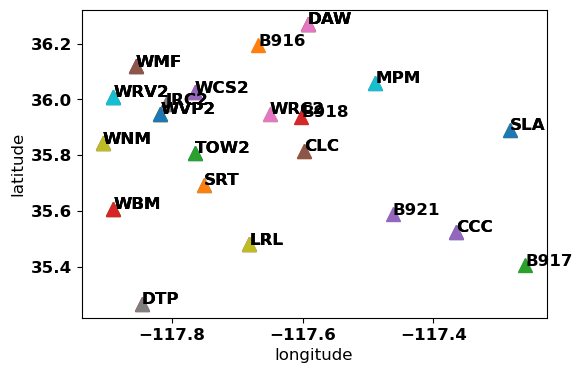

In [ ]:
stations_new = pd.read_csv('./example/stations.csv',sep=',')
center = (-117.6, 35.8) ## Modify here according to your stations
x_min, y_min = center[0] - 1, center[1] - 1

PLOT = 1

if PLOT == 1:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for i,sta in enumerate(stations_new['station']):
        ax.plot(stations_new['longitude'][i],stations_new['latitude'][i],'^',markersize=10)
        ax.text(stations_new['longitude'][i],stations_new['latitude'][i],sta)

    ax.locator_params(axis='both', nbins=6)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    # ax.set_xlim(x_min, x_min+2); 
    # ax.set_ylim(y_min, y_min+2)

### load trained PhaseNO model

In [ ]:
model = PhaseNO.load_from_checkpoint('./models/epoch=19-step=1140000.ckpt', map_location=device)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../model/epoch=19-step=1140000.ckpt`


PhaseNO(
  (criterion): BCEWithLogitsLoss()
  (fc0): Linear(in_features=6, out_features=48, bias=True)
  (fno0): FNO1D(
    (conv): SpectralConv1d()
    (w): pointwise_op_1D(
      (conv): Conv1d(48, 48, kernel_size=(1,), stride=(1,))
    )
    (normalize_layer): InstanceNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (gno0): GNO()
  (fno1): FNO1D(
    (conv): SpectralConv1d()
    (w): pointwise_op_1D(
      (conv): Conv1d(48, 96, kernel_size=(1,), stride=(1,))
    )
    (normalize_layer): InstanceNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (gno1): GNO()
  (fno2): FNO1D(
    (conv): SpectralConv1d()
    (w): pointwise_op_1D(
      (conv): Conv1d(96, 192, kernel_size=(1,), stride=(1,))
    )
    (normalize_layer): InstanceNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (gno3): GNO()
  (fno4): FNO1D(
    (conv): SpectralConv1d()
    (w): pointwise_op_1D(
      (conv): Conv1d(384, 96

### Set data path and parameters here

In [ ]:
Data_Path   = './example/waveforms' # folder contains raw data

PROB = 1 # use 1 if you want to output predicted probability time series and then plotting with phaseno_plot.ipynb
# consider PROB = 0 to save storage if processing a large amount of data 
PICK = 1 # use 1 to output picks using a pikcing threshold (default threshold is 0.3)

if PROB == 1:
    output_name = './example/results/probability'
    prob_dir = os.path.join(output_name)
    if not os.path.exists(prob_dir):
        os.makedirs(prob_dir)

if PICK == 1:
    result_name = './example/results/picks'
    result_dir = os.path.join(result_name)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

timestamp = datetime(2019, 7, 6, 8, 0)
timeend   = datetime(2019, 7, 6, 9, 0) # end time of all data (not included)
threshold = 0.3 # probability threshold for picking
# (never needed in version 1.0.1) num_station_split = 18 # number of stations in a run 
# (never needed in version 1.0.1) num_station_onerun_max = 26 # maximum number of stations in a run on a GPU

# NEW: I impose a physical distance constraint such that each station communicates only with neighboring stations within a predefined range (dis_range).
dis_range = 30 # unit in km 

in_samples = 3000 # time window is 30 s in a run
overlap = 1000 # use a 10-s overlap between two time windows
steps = in_samples - overlap
sample_rate = 100
highpass_filter = 1 # Hz
eps = 1e-6
dtype = 'float32'
n_channel = 3

### start predicting and picking

In [10]:
label_name=["P_Prob","S_Prob"]
record = namedtuple("phase", ["fname", "station_id", "t0", "p_idx", "p_prob", "s_idx", "s_prob"])

# loop over hourly data segment
while timestamp < timeend:
    
    picks_all_stations = []
    amps_all_stations  = []

    itime = timestamp.strftime("%Y-%m-%dT%H:%M")
    print('current at', itime)

    station_all = []
    for fname in os.listdir(Data_Path):# The list is in arbitrary order
        if itime in fname:   
            channel_name = fname.split('.')[2]
            station_name = fname.split('.')[1]
            network_name = fname.split('.')[0]
            station_all.append(network_name+'.'+station_name+'.'+channel_name)

    print('number of stations at ', itime, ': ', len(station_all))

    station_select = list(np.unique(station_all))

    print('selected station in one sample: ', station_select)

    networks = []
    stations = []
    channels = []
    ids = []
    comps = []
    ress = []
    units = []
    for sta in station_select:
        ch = sta.split('.')[-1]
        st = sta.split('.')[1]
        ne = sta.split('.')[0]
        channels.append(ch)
        stations.append(st)
        networks.append(ne)
        temp = stations_new.loc[stations_new['station'] == st]
        sta_select = temp.loc[temp['channel'] == ch]
        ids.append(sta_select.iloc[0]['id'])
        comps.append(sta_select.iloc[0]['component'])
        ress.append(sta_select.iloc[0]['response'])
        units.append(sta_select.iloc[0]['unit'])

    d = {'id': ids,
        'network': networks, 
        'station': stations, 
        'channel': channels,
        'component': comps,
        'response': ress,
        'unit': units}
    df = pd.DataFrame(data=d)

    num_station = len(stations)

    station_convert = []
    for i, sta in enumerate(stations):
        station_0_1_ = [(stations_new.loc[stations_new['station'] == sta].iloc[0]['longitude']- x_min)/2, 
                        (stations_new.loc[stations_new['station'] == sta].iloc[0]['latitude']- y_min)/2]
        station_convert.append(station_0_1_)
    station_convert = torch.from_numpy(np.array(station_convert)).float()

    # generate edge_index
    row_a=[]
    row_b=[]  
    row_ix=[]
    row_iy=[]
    row_jx=[]
    row_jy=[]
    for i in range(num_station):
        for j in range(num_station):
            dis = np.sqrt((station_convert[i,0] - station_convert[j,0])**2 + (station_convert[i,1] - station_convert[j,1])**2)
            if dis <= dis_range/222: 
                row_a.append(i)
                row_b.append(j)
                row_ix.append(station_convert[i,0])
                row_iy.append(station_convert[i,1])
                row_jx.append(station_convert[j,0])
                row_jy.append(station_convert[j,1])

    edge_index=[row_a,row_b,row_ix,row_iy,row_jx,row_jy]
    edge_index = torch.from_numpy(np.array(edge_index)).float().to(device)
    
    picks_select_stations = []
    print('------------------------ reading waveforms ------------------------')

    fname = []
    bg_st=obspy.core.Stream()
    for net,sta,cha in tqdm(zip(df['network'],df['station'],df['channel'])): 
        
        fname.append(net+'.'+sta+'.'+cha+'.'+itime+'.mseed')
        mseed = obspy.read(os.path.join(Data_Path,net+'.'+sta+'.'+cha+'.'+itime+'.mseed'))
        #mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)
        
        # for trace in mseed:  # if the sampling rate in downloaded data is a float closed to 100.0, e.g., 99.99
        #     trace.stats.sampling_rate = 100.0            
        mseed = mseed.merge(fill_value="latest")
        mseed = mseed.detrend("demean")

        if highpass_filter > 0:
            mseed = mseed.filter("highpass", freq=highpass_filter)

        if len(mseed) < 3:
            for r in np.arange(3-len(mseed)):
                mseed.append(mseed[0])

        bg_st += mseed[:3]

    starttime = min([st.stats.starttime for st in bg_st])
    endtime = max([st.stats.endtime for st in bg_st])
    bg_st = bg_st.trim(starttime, endtime, pad=True, fill_value=0)
    split_points=list(range(3,len(bg_st),3))

    ##### process raw amplitude for magnitude estimation #####  

    nt = len(bg_st[0].data)
    raw_amp = []
    for ista in range(num_station):
        trace_amp = np.zeros([nt, n_channel], dtype=dtype)
        id = df.iloc[ista]["id"]
        comp = df.iloc[ista]["component"].split(",")
        #resp = df.iloc[ista]["response"].split(",")

        for ich in np.arange(n_channel):
            ii = ista*n_channel+ich
            ## accerleration to velocity
            if df.iloc[ista]["unit"] == "m/s**2":
                bg_st[ii] = bg_st[ii].integrate().filter("highpass", freq=highpass_filter)

            tmp = bg_st[ii].data.astype(dtype)

            trace_amp[:, ich] = tmp[:nt]

        raw_amp.append(trace_amp)

    raw_amp_temp = np.transpose(np.concatenate(raw_amp, axis=1))
    data_raw  = np.split(raw_amp_temp[:,:360000],split_points)

    preds = []
    starts = []
    trace_stats=[]
    for ii in list(range(0,len(bg_st),3)):
        tr = bg_st[ii]
        trace_stats.append(tr.stats)

    starttime = min([st.starttime for st in trace_stats])
    t0 = starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
    print('t0=', t0)

    print('------------------------ start predicting ------------------------')

    for index, windowed_st in enumerate(tqdm(bg_st.slide(window_length=in_samples/sample_rate, step=steps/100.0,include_partial_windows=True))): 
        s = index*steps#windowed_st[0].stats.starttime
        if len(windowed_st)!=len(bg_st):
            print('skip')
            preds.append(np.zeros((num_station,2,in_samples)))
            starts.append(s)
            continue
        start_trim = min([tr.stats.starttime for tr in windowed_st])
        end_trim = max([tr.stats.endtime for tr in windowed_st])
        windowed_st.trim(start_trim, max(start_trim+in_samples/sample_rate, end_trim) , pad=True, fill_value=0)
        temp = np.array(windowed_st)[:,-in_samples:]
        temp = np.split(temp,split_points)
        temp = np.array(temp,dtype=float)

        temp_mean = np.mean(temp,axis=-1,keepdims=True)
        temp_std  = np.std(temp,axis=-1,keepdims=True)
        temp = (temp-temp_mean)/(temp_std+eps)

        X = np.zeros((num_station, 3+2, in_samples))
        X[:,:3,:] = temp/10

        for istation in np.arange(num_station):
            X[istation,3,:] = station_convert[istation,0]
            X[istation,4,:] = station_convert[istation,1]

        X = torch.tensor(X, dtype=torch.float)
        X = X.to(device)
        res=torch.sigmoid(model.forward((X,None,edge_index)))
        preds.append(res.cpu().detach().numpy())
        starts.append(s)

    print('------------------------ start post-processing ------------------------')

    del bg_st
    gc.collect()

    prediction_sample_factor=1
    # Maximum number of predictions covering a point
    coverage = int(
        np.ceil(in_samples / (in_samples - overlap) + 1)
    )
    
    pred_length = int(
        np.ceil(
            (np.max(starts)+in_samples) * prediction_sample_factor
        )
    )
    pred_merge = (
        np.zeros_like(
            preds[0], shape=( preds[0].shape[0],preds[0].shape[1], pred_length, coverage)
        )
        * np.nan
    )

    for i, (pred, start) in enumerate(zip(preds, starts)):
                    pred_start = int(start * prediction_sample_factor)
                    pred_merge[
                        :,:, pred_start : pred_start + pred.shape[2], i % coverage
                    ] = pred

    del preds
    gc.collect()

    if PICK == 1:

        p_idx, p_prob, s_idx, s_prob = [], [], [], []
        picks_part_stations = []
        for k in range(num_station):
            id = fname[k]
            sta = stations[k]
            pred = np.nanmean(pred_merge[k], axis=-1)
            P_seq, _, _ = _trim_nan(pred[0])
            S_seq, _, _ = _trim_nan(pred[1])
            p, p_pro =_detect_peaks(P_seq[:360000], mph=threshold, mpd=1.0*sample_rate)
            s, s_pro =_detect_peaks(S_seq[:360000], mph=threshold, mpd=1.0*sample_rate)

            picks_part_stations.append(record(id, sta, t0, list(p), list(p_pro), list(s), list(s_pro)))

        amps_part_stations = extract_amplitude(data_raw, picks_part_stations, window_p=8, window_s=4, dt=1/sample_rate)
        
        picks_all_stations += picks_part_stations
        amps_all_stations += amps_part_stations

    if PROB == 1:
        for k in range(num_station):

            #id = fname[k]
            output = obspy.Stream()
            pred = np.nanmean(pred_merge[k], axis=-1)

            for i in range(2):

                trimmed_pred, f, _ = _trim_nan(pred[i])
                trimmed_start = trace_stats[k].starttime + f / sample_rate

                output.append(
                    obspy.Trace(
                        trimmed_pred,
                        {
                            "starttime": trimmed_start,
                            "sampling_rate": sample_rate,
                            "network": trace_stats[k].network,
                            "station": trace_stats[k].station,
                            "location": trace_stats[k].location,
                            "channel": label_name[i],
                        },
                    )
                )

            output.write(os.path.join(prob_dir, trace_stats[k].network+'.'+trace_stats[k].station+'.'+channels[k]+'.'+itime+'.mseed'), format='MSEED')
            del output
            gc.collect()

    del pred_merge
    gc.collect()


    print('========================',itime,' done ========================')

    if PICK == 1:
        save_picks_json(picks_all_stations, result_dir, dt=1/sample_rate, amps=amps_all_stations,fname='picks_'+itime+'.json')

    timestamp = timestamp + timedelta(hours=1)

current at 2019-07-06T08:00
number of stations at  2019-07-06T08:00 :  36
selected station in one sample:  ['CI.CCC.HH', 'CI.CCC.HN', 'CI.CLC.HH', 'CI.CLC.HN', 'CI.DAW.HH', 'CI.DAW.HN', 'CI.JRC2.HH', 'CI.JRC2.HN', 'CI.LRL.HH', 'CI.LRL.HN', 'CI.MPM.HH', 'CI.MPM.HN', 'CI.SLA.HH', 'CI.SLA.HN', 'CI.SRT.HH', 'CI.SRT.HN', 'CI.TOW2.HH', 'CI.TOW2.HN', 'CI.WBM.HH', 'CI.WBM.HN', 'CI.WCS2.HH', 'CI.WCS2.HN', 'CI.WMF.HH', 'CI.WMF.HN', 'CI.WNM.EH', 'CI.WNM.HN', 'CI.WRC2.HH', 'CI.WRC2.HN', 'CI.WRV2.EH', 'CI.WRV2.HN', 'CI.WVP2.EH', 'CI.WVP2.HN', 'PB.B916.EH', 'PB.B917.EH', 'PB.B918.EH', 'PB.B921.EH']
------------------------ reading waveforms ------------------------


36it [00:16,  2.23it/s]


t0= 2019-07-06T07:59:59.998
------------------------ start predicting ------------------------


180it [01:30,  1.98it/s]


------------------------ start post-processing ------------------------
======================== 2019-07-06T08:00  done ========================
